In [1]:
import pandas as pd
import numpy as np
import pickle
import random
from itertools import permutations
from plotnine import *

In [2]:
aa_list = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
assert len(aa_list) == 20

In [3]:
# define a wildtype sequence (10aa in length)
random.seed(1)
wt_seq = ''.join(random.choices(aa_list, k=10))
print("The wildtype sequence is: " + wt_seq)

The wildtype sequence is: NTSQIHFSRA


In [4]:
# generate a bunch of unique identifiers to act as 8nt barcodes
nuc_list = ['A','T','C','G']

bc_list = []
random.seed(2)
for i in range(10000):
    bc = ''.join(random.choices(nuc_list, k=8))
    if bc not in bc_list:
        bc_list.append(bc)

print("Generated " + str(len(bc_list)) + " unique barcodes.")

Generated 9226 unique barcodes.


In [65]:
# define a function for logging the mutations in a variant sequence
def defineMutations(wt_seq, var_seq):
    muts = []
    for i in range(len(wt_seq)):
        if var_seq[i] != wt_seq[i]:
            muts.append(wt_seq[i] + str(i+1) + var_seq[i])
    return muts

# define a function for estimated escape fraction given variant sequence
def escapeEstimate(var_seq, mut_sites):
    bad_muts_for_ep1 = ['A','C','D','E']
    bad_muts_for_ep2 = ['Y','W','V','T']
    bad_sites_for_ep1 = [0,1,2]
    bad_sites_for_ep2 = [7,9]
    
    ep1_present = False
    ep2_present = False
    if len(mut_sites) == 0:
        """if WT sequence, then probability of unbound antibody is very low"""
        prob_unbound_1 = max(random.gauss(0.05, 0.1), 0)
        prob_unbound_2 = max(random.gauss(0.05, 0.1), 0)
    elif len(mut_sites) > 0:
        for site in mut_sites:
            if site in bad_sites_for_ep1 and var_seq[site] in bad_muts_for_ep1:
                ep1_present = True
            elif site in bad_sites_for_ep2 and var_seq[site] in bad_muts_for_ep2:
                ep2_present = True
        if ep1_present == True:
            prob_unbound_1 = min(random.gauss(0.9, 0.1), 1)
        else:
            prob_unbound_1 = max(random.gauss(0.05, 0.1), 0)
        if ep2_present == True:
            prob_unbound_2 = min(random.gauss(0.9, 0.1), 1)
        else:
            prob_unbound_2 = max(random.gauss(0.05, 0.1), 0)
            
    return prob_unbound_1, prob_unbound_2, prob_unbound_1*prob_unbound_2, ep1_present, ep2_present

In [87]:
def simulateDataset(wt_seq, aa_list, bc_list, num_mut_exp): 
    data = []  
    for bc in range(len(bc_list)):
        # randomly sample number of mutations from poisson distribution with lambda = num_mut_exp
        num_mut = min(int(np.random.poisson(num_mut_exp,1)), len(wt_seq))
        
        if num_mut > 0:
            # randomly sample sites for those mutations
            idx_of_sites = list(range(len(wt_seq)))
            mut_sites = random.sample(idx_of_sites, num_mut) # [3,10], 0-indexed
        else:
            mut_sites = []  
        assert len(mut_sites) == num_mut
        
        # randomly sample amino acid changes at those sites and construct the variant sequence
        var_seq = ''
        for idx in range(len(wt_seq)):
            temp_aa_list = aa_list.copy()
            if idx not in mut_sites:
                var_seq += str(wt_seq[idx])
            else:
                temp_aa_list.remove(wt_seq[idx])
                var_seq += str(random.choices(temp_aa_list, k=1)[0])

        # estimate probabilities of escape
        prob_unbound_1, prob_unbound_2, score, ep1_present, ep2_present = escapeEstimate(var_seq, mut_sites)
        
        # epitope escape
        if ep1_present == True and ep2_present == True:
            escape = 'escape12'
        elif ep1_present == True and ep2_present == False:
            escape = 'escape1'
        elif ep1_present == False and ep2_present == True:
            escape = 'escape2'
        else:
            escape = 'none'
        
        assert len(defineMutations(wt_seq, var_seq)) == num_mut

        # generate dataframe
        data.append(
        {
            'variant': var_seq,
            'library': "lib_sim",
            'barcode': bc_list[bc],
            'aa_substitutions': ' '.join(defineMutations(wt_seq, var_seq)),
            'n_aa_substitutions': num_mut,
            'prob_bound_1': prob_unbound_1,
            'prob_bound_2': prob_unbound_2,
            'escape': escape,
            'score': score
        })
    res = pd.DataFrame(data)
    return res

In [98]:
random.seed(1)
res = simulateDataset(wt_seq, aa_list, bc_list, 2)

In [99]:
res

,variant,library,barcode,aa_substitutions,n_aa_substitutions,prob_bound_1,prob_bound_2,escape,score
0,NNPQHHFSRA,lib_sim,GGAAGCCT,T2N S3P I5H,3,0.000068,0.097117,none,0.000007
1,ITSQIHSARA,lib_sim,CCCATTCG,N1I F7S S8A,3,0.000000,0.103800,none,0.000000
2,NTSMIHFSRA,lib_sim,GCTTAATT,Q4M,1,0.119978,0.102354,none,0.012280
3,YTSQIHFSHQ,lib_sim,TGCCAATA,N1Y R9H A10Q,3,0.028571,0.061412,none,0.001755
4,NTSKIHFEFA,lib_sim,CGCAGGCG,Q4K S8E R9F,3,0.066952,0.000000,none,0.000000
...,...,...,...,...,...,...,...,...,...
9221,NTEEIHFSWA,lib_sim,CCGCTACC,S3E Q4E R9W,3,0.964943,0.049355,escape1,0.047625
9222,NTSQIHFSRA,lib_sim,ATCCTCCG,,0,0.109979,0.177371,none,0.019507
9223,NTYQIHFSRA,lib_sim,TTTTAGAC,S3Y,1,0.244869,0.026447,none,0.006476
9224,NKTQPYFWEC,lib_sim,GCCTGTGC,T2K S3T I5P H6Y S8W R9E A10C,7,0.000000,0.975097,escape2,0.000000


In [100]:
# check how many variants are duplicated
# remove duplicated columns (keeping first appearance of the variant here)
print(len(np.unique(np.asarray(res['variant']))))
res = res.drop_duplicates('variant', keep = 'first')
res

5455


,variant,library,barcode,aa_substitutions,n_aa_substitutions,prob_bound_1,prob_bound_2,escape,score
0,NNPQHHFSRA,lib_sim,GGAAGCCT,T2N S3P I5H,3,0.000068,0.097117,none,0.000007
1,ITSQIHSARA,lib_sim,CCCATTCG,N1I F7S S8A,3,0.000000,0.103800,none,0.000000
2,NTSMIHFSRA,lib_sim,GCTTAATT,Q4M,1,0.119978,0.102354,none,0.012280
3,YTSQIHFSHQ,lib_sim,TGCCAATA,N1Y R9H A10Q,3,0.028571,0.061412,none,0.001755
4,NTSKIHFEFA,lib_sim,CGCAGGCG,Q4K S8E R9F,3,0.066952,0.000000,none,0.000000
...,...,...,...,...,...,...,...,...,...
9219,MHSQIHFLRA,lib_sim,TGGCCGCA,N1M T2H S8L,3,0.021090,0.097676,none,0.002060
9220,NTSQIHYVRA,lib_sim,CAATCTTT,F7Y S8V,2,0.000000,1.000000,escape2,0.000000
9221,NTEEIHFSWA,lib_sim,CCGCTACC,S3E Q4E R9W,3,0.964943,0.049355,escape1,0.047625
9224,NKTQPYFWEC,lib_sim,GCCTGTGC,T2K S3T I5P H6Y S8W R9E A10C,7,0.000000,0.975097,escape2,0.000000


In [101]:
res.sort_values(by=['score'], ascending=False)

,variant,library,barcode,aa_substitutions,n_aa_substitutions,prob_bound_1,prob_bound_2,escape,score
7696,DTSWIHQSRV,lib_sim,ATGTGAGG,N1D Q4W F7Q A10V,4,1.000000,1.000000,escape12,1.0
517,AGSQIHFSRT,lib_sim,TAGCGCAT,N1A T2G A10T,3,1.000000,1.000000,escape12,1.0
3320,NAEQIVFWRT,lib_sim,GGATGCAG,T2A S3E H6V S8W A10T,5,1.000000,1.000000,escape12,1.0
6320,RASQIHFSRT,lib_sim,GAGAGCCG,N1R T2A A10T,3,1.000000,1.000000,escape12,1.0
3984,NESQDSFTRA,lib_sim,CACAACAG,T2E I5D H6S S8T,4,1.000000,1.000000,escape12,1.0
...,...,...,...,...,...,...,...,...,...
3999,NTSQILFSTA,lib_sim,GGAATCGA,H6L R9T,2,0.000000,0.107380,none,0.0
4000,NTSQIAFSWA,lib_sim,TCGATTGC,H6A R9W,2,0.067176,0.000000,none,0.0
4009,WIHFIAFSRQ,lib_sim,TACTTCGC,N1W T2I S3H Q4F H6A A10Q,6,0.000000,0.127215,none,0.0
4010,NTRQIHLSII,lib_sim,GGCGTATG,S3R F7L R9I A10I,4,0.000000,0.000000,none,0.0


/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


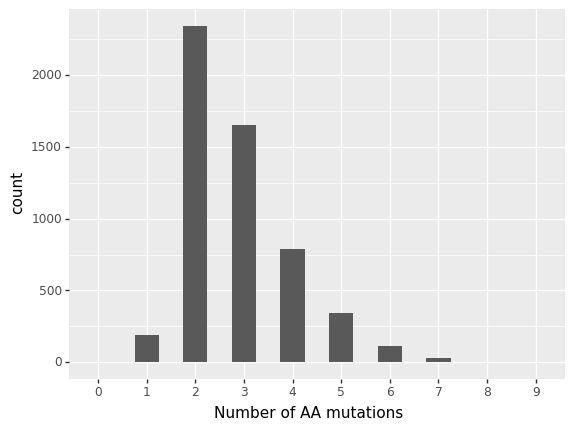

<ggplot: (8773800657705)>

In [102]:
# take a look at distribution of number of AA substitutions
ggplot(res, aes(x = 'factor(n_aa_substitutions)')) + geom_histogram(binwidth=0.5) + labs(x = 'Number of AA mutations')

/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


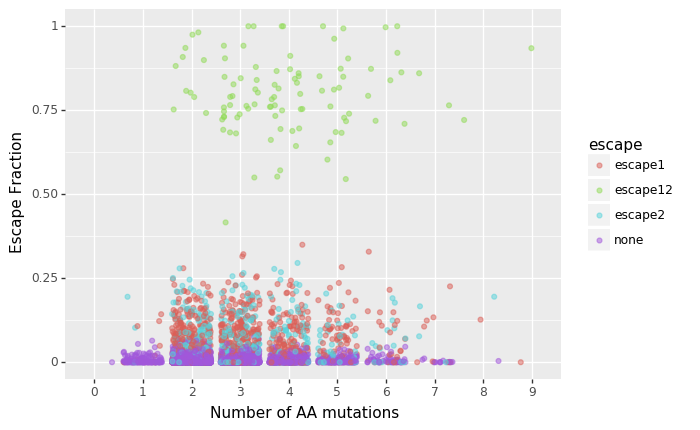

<ggplot: (8773801062217)>

In [104]:
ggplot(res, aes(x = 'factor(n_aa_substitutions)', y = 'score')) + geom_jitter(aes(color = 'escape'), alpha = 0.5) + labs(x = 'Number of AA mutations', y = 'Escape Fraction')

In [105]:
# save dataset
with open("02-08-2021-sim-multimutant.pkl", "wb") as f:
      pickle.dump([res, wt_seq], f)